In [5]:
## Standard libraries
import os
import math
import time
import numpy as np 
import pandas as pd 

## Imports for plotting
import matplotlib.pyplot as plt 
%matplotlib inline 
from IPython.display import set_matplotlib_formats 
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install pytorch-lightning==1.3.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data" 
CHECKPOINT_PATH = "../saved_models/tutorial11" 

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device) 

from torch.multiprocessing import Pool, Process, set_start_method
try:
     set_start_method('spawn')
except RuntimeError:
    pass

Global seed set to 42


Using device cuda:0


In [6]:
device = torch.device("cpu")

In [8]:
!pip install -q gdown 
!gdown --id 1h5FNFNJHD36LOngGhCsl_aygSXvhJc_U
!gdown --id 1mDa8ADMO0ByuAch6zlDPCgX7La0sy9Fd

Downloading...
From: https://drive.google.com/uc?id=1h5FNFNJHD36LOngGhCsl_aygSXvhJc_U
To: /content/cartoon_resized.npy
31.9MB [00:00, 56.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1mDa8ADMO0ByuAch6zlDPCgX7La0sy9Fd
To: /content/filtered_data_binary.csv
100% 106k/106k [00:00<00:00, 930kB/s]


In [9]:
import PIL 
def grayscale(arr): 
    arr = arr.astype(np.uint8) 
    arr = PIL.Image.fromarray(arr).resize(size=(52,52)).convert("L")
    arr = np.expand_dims(np.array(arr), axis=0) 
    return torch.Tensor(arr) 

In [10]:
cartoon_features = pd.read_csv("filtered_data_binary.csv") 
cartoon_features = cartoon_features.drop(["filename"], axis=1) 
cartoon_features = cartoon_features.values 

In [11]:
cartoon_resized = np.load("cartoon_resized.npy") 

In [12]:
cartoon_data = list(map(lambda x, y: (torch.Tensor(np.expand_dims(x, axis=0)).to(device), y), cartoon_resized, cartoon_features))  

In [13]:
pl.seed_everything(42)
train_set, val_set, test_set = torch.utils.data.random_split(cartoon_data, [2300, 449, 200]) 

train_loader = data.DataLoader(train_set, batch_size=256, shuffle=False, drop_last=False) 
val_loader = data.DataLoader(val_set, batch_size=64, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=64, shuffle=False, drop_last=False, num_workers=4) 

Global seed set to 42
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [14]:
from torch.distributions.transforms import Transform 

class NF(Transform): 

    def __init__(self, flows, import_samples=8): 
        super().__init__() 
        self.flows = nn.ModuleList(flows) 
        self.impport_samples = import_samples 

    def _call(self, inputs): 
        z, ldj = self.encode(inputs) 
        return z 
    
    @torch.no_grad() 
    def _inverse(self, inputs): 
        ldj = torch.zeros(img_shape[0], device=device) 
        for flow in reversed(flows): 
            inputs, ldj = flow(inputs, ldj, reverse=True) 
        return inputs 

    def log_abs_det_jacobian(self, x, y): 
        z, ldj = self.encode(x) 
        return ldj 
    
    
    def encode(self, imgs):
        # Given a batch of images, return the latent representation z and ldj of the transformations
        z, ldj = imgs, torch.zeros(imgs.shape[0], device=self.device)
        for flow in self.flows:
            z, ldj = flow(z, ldj, reverse=False)
        return z, ldj 
    
    
    def _get_likelihood(self, imgs, return_ll=False):
        """
        Given a batch of images, return the likelihood of those. 
        If return_ll is True, this function returns the log likelihood of the input.
        Otherwise, the ouptut metric is bits per dimension (scaled negative log likelihood)
        """
        z, ldj = self.encode(imgs)
        log_pz = self.prior.log_prob(z).sum(dim=[1,2,3])
        log_px = ldj + log_pz
        nll = -log_px
        # Calculating bits per dimension
        bpd = nll * np.log2(np.exp(1)) / np.prod(imgs.shape[1:])
        return bpd.mean() if not return_ll else log_px
        
        
    @torch.no_grad()
    def sample(self, img_shape, z_init=None):
        """
        Sample a batch of images from the flow.
        """
        # Sample latent representation from prior
        if z_init is None:
            z = self.prior.sample(sample_shape=img_shape).to(device)
        else:
            z = z_init.to(device)
        
        # Transform z to x by inverting the flows
        ldj = torch.zeros(img_shape[0], device=device)
        for flow in reversed(self.flows):
            z, ldj = flow(z, ldj, reverse=True)
        return z
    
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        # An scheduler is optional, but can help in flows to get the last bpd improvement
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99)
        return [optimizer], [scheduler] 


In [15]:
class ImageFlow(pl.LightningModule):
    
    def __init__(self, flows, import_samples=8):
        """
        Inputs:
            flows - A list of flows (each a nn.Module) that should be applied on the images. 
            import_samples - Number of importance samples to use during testing (see explanation below). Can be changed at any time
        """
        super().__init__()
        self.flows = nn.ModuleList(flows)
        self.import_samples = import_samples
        # Create prior distribution for final latent space
        self.prior = torch.distributions.normal.Normal(loc=0.0, scale=1.0)
        # Example input for visualizing the graph
        self.example_input_array = train_set[0][0].unsqueeze(dim=0)
        
        
    def forward(self, imgs):
        # The forward function is only used for visualizing the graph
        return self._get_likelihood(imgs)
    
    
    def encode(self, imgs):
        # Given a batch of images, return the latent representation z and ldj of the transformations
        z, ldj = imgs, torch.zeros(imgs.shape[0], device=self.device)
        for flow in self.flows:
            z, ldj = flow(z, ldj, reverse=False)
        return z, ldj
    
    
    def _get_likelihood(self, imgs, return_ll=False):
        """
        Given a batch of images, return the likelihood of those. 
        If return_ll is True, this function returns the log likelihood of the input.
        Otherwise, the ouptut metric is bits per dimension (scaled negative log likelihood)
        """
        z, ldj = self.encode(imgs)
        log_pz = self.prior.log_prob(z).sum(dim=[1,2,3])
        log_px = ldj + log_pz
        nll = -log_px
        # Calculating bits per dimension
        bpd = nll * np.log2(np.exp(1)) / np.prod(imgs.shape[1:])
        return bpd.mean() if not return_ll else log_px
        
        
    @torch.no_grad()
    def sample(self, img_shape, z_init=None):
        """
        Sample a batch of images from the flow.
        """
        # Sample latent representation from prior
        if z_init is None:
            z = self.prior.sample(sample_shape=img_shape).to(device)
        else:
            z = z_init.to(device)
        
        # Transform z to x by inverting the flows
        ldj = torch.zeros(img_shape[0], device=device)
        for flow in reversed(self.flows):
            z, ldj = flow(z, ldj, reverse=True)
        return z
    
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        # An scheduler is optional, but can help in flows to get the last bpd improvement
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99)
        return [optimizer], [scheduler]
    
    
    def training_step(self, batch, batch_idx):
        # Normalizing flows are trained by maximum likelihood => return bpd
        loss = self._get_likelihood(batch[0])                             
        self.log('train_bpd', loss)
        return loss
    
    
    def validation_step(self, batch, batch_idx):
        loss = self._get_likelihood(batch[0])
        self.log('val_bpd', loss)
    
    
    def test_step(self, batch, batch_idx):
        # Perform importance sampling during testing => estimate likelihood M times for each image
        samples = []
        for _ in range(self.import_samples):
            img_ll = self._get_likelihood(batch[0], return_ll=True)
            samples.append(img_ll)
        img_ll = torch.stack(samples, dim=-1)
        
        # To average the probabilities, we need to go from log-space to exp, and back to log.
        # Logsumexp provides us a stable implementation for this
        img_ll = torch.logsumexp(img_ll, dim=-1) - np.log(self.import_samples)
        
        # Calculate final bpd
        bpd = -img_ll * np.log2(np.exp(1)) / np.prod(batch[0].shape[1:])
        bpd = bpd.mean()
        
        self.log('test_bpd', bpd)

In [16]:
class Dequantization(nn.Module):
    
    def __init__(self, alpha=1e-5, quants=256):
        """
        Inputs:
            alpha - small constant that is used to scale the original input. 
                    Prevents dealing with values very close to 0 and 1 when inverting the sigmoid
            quants - Number of possible discrete values (usually 256 for 8-bit image)
        """
        super().__init__()
        self.alpha = alpha
        self.quants = quants 
        
    def forward(self, z, ldj, reverse=False):
        if not reverse:
            z, ldj = self.dequant(z, ldj)
            z, ldj = self.sigmoid(z, ldj, reverse=True)
        else:
            z, ldj = self.sigmoid(z, ldj, reverse=False)
            z = z * self.quants
            ldj += np.log(self.quants) * np.prod(z.shape[1:])
            z = torch.floor(z).clamp(min=0, max=self.quants-1).to(torch.int32)
        return z, ldj
    
    def sigmoid(self, z, ldj, reverse=False):
        # Applies an invertible sigmoid transformation
        if not reverse:
            ldj += (-z-2*F.softplus(-z)).sum(dim=[1,2,3])
            z = torch.sigmoid(z)
        else:
            z = z * (1 - self.alpha) + 0.5 * self.alpha  # Scale to prevent boundaries 0 and 1
            ldj += np.log(1 - self.alpha) * np.prod(z.shape[1:])
            ldj += (-torch.log(z) - torch.log(1-z)).sum(dim=[1,2,3])
            z = torch.log(z) - torch.log(1-z)
        return z, ldj
    
    def dequant(self, z, ldj):
        # Transform discrete values to continuous volumes
        z = z.to(torch.float32)
        z = z + torch.rand_like(z).detach()
        z = z / self.quants
        ldj -= np.log(self.quants) * np.prod(z.shape[1:])
        return z, ldj


class VariationalDequantization(Dequantization):
    
    def __init__(self, var_flows, alpha=1e-5):
        """
        Inputs: 
            var_flows - A list of flow transformations to use for modeling q(u|x)
            alpha - Small constant, see Dequantization for details
        """
        super().__init__(alpha=alpha)
        self.flows = nn.ModuleList(var_flows)
        
    def dequant(self, z, ldj):
        z = z.to(torch.float32)
        img = (z / 255.0) * 2 - 1 # We condition the flows on x, i.e. the original image
        
        # Prior of u is a uniform distribution as before
        # As most flow transformations are defined on [-infinity,+infinity], we apply an inverse sigmoid first.
        deq_noise = torch.rand_like(z).detach()
        deq_noise, ldj = self.sigmoid(deq_noise, ldj, reverse=True)
        for flow in self.flows:
            deq_noise, ldj = flow(deq_noise, ldj, reverse=False, orig_img=img)
        deq_noise, ldj = self.sigmoid(deq_noise, ldj, reverse=False)
        
        # After the flows, apply u as in standard dequantization
        z = (z + deq_noise) / 256.0
        ldj -= np.log(256.0) * np.prod(z.shape[1:])
        return z, ldj

In [17]:
def create_checkerboard_mask(h, w, invert=False):
    x, y = torch.arange(h, dtype=torch.int32), torch.arange(w, dtype=torch.int32)
    xx, yy = torch.meshgrid(x, y)
    mask = torch.fmod(xx + yy, 2)
    mask = mask.to(torch.float32).view(1, 1, h, w)
    if invert:
        mask = 1 - mask
    return mask

def create_channel_mask(c_in, invert=False):
    mask = torch.cat([torch.ones(c_in//2, dtype=torch.float32), 
                      torch.zeros(c_in-c_in//2, dtype=torch.float32)])
    mask = mask.view(1, c_in, 1, 1)
    if invert:
        mask = 1 - mask
    return mask

In [18]:
class CouplingLayer(nn.Module):
    
    def __init__(self, network, mask, c_in):
        """
        Coupling layer inside a normalizing flow.
        Inputs:
            network - A PyTorch nn.Module constituting the deep neural network for mu and sigma.
                      Output shape should be twice the channel size as the input.
            mask - Binary mask (0 or 1) where 0 denotes that the element should be transformed,
                   while 1 means the latent will be used as input to the NN.
            c_in - Number of input channels
        """
        super().__init__()
        self.network = network
        self.scaling_factor = nn.Parameter(torch.zeros(c_in))
        # Register mask as buffer as it is a tensor which is not a parameter, 
        # but should be part of the modules state.
        self.register_buffer('mask', mask)
    
    def forward(self, z, ldj, reverse=False, orig_img=None):
        """
        Inputs:
            z - Latent input to the flow
            ldj - The current ldj of the previous flows. 
                  The ldj of this layer will be added to this tensor.
            reverse - If True, we apply the inverse of the layer.
            orig_img (optional) - Only needed in VarDeq. Allows external
                                  input to condition the flow on (e.g. original image)
        """
        # Apply network to masked input
        z_in = z * self.mask
        if orig_img is None:
            nn_out = self.network(z_in)
        else:
            nn_out = self.network(torch.cat([z_in, orig_img], dim=1))
        s, t = nn_out.chunk(2, dim=1)
        
        # Stabilize scaling output
        s_fac = self.scaling_factor.exp().view(1, -1, 1, 1)
        s = torch.tanh(s / s_fac) * s_fac
        
        # Mask outputs (only transform the second part)
        s = s * (1 - self.mask)
        t = t * (1 - self.mask)
        
        # Affine transformation
        if not reverse:
            # Whether we first shift and then scale, or the other way round,
            # is a design choice, and usually does not have a big impact
            z = (z + t) * torch.exp(s)
            ldj += s.sum(dim=[1,2,3])
        else:
            z = (z * torch.exp(-s)) - t
            ldj -= s.sum(dim=[1,2,3])
            
        return z, ldj

In [19]:
class ConcatELU(nn.Module):
    """
    Activation function that applies ELU in both direction (inverted and plain). 
    Allows non-linearity while providing strong gradients for any input (important for final convolution)
    """
    
    def forward(self, x):
        return torch.cat([F.elu(x), F.elu(-x)], dim=1)

    
class LayerNormChannels(nn.Module):
    
    def __init__(self, c_in):
        """
        This module applies layer norm across channels in an image. Has been shown to work well with ResNet connections.
        Inputs: 
            c_in - Number of channels of the input
        """
        super().__init__()
        self.layer_norm = nn.LayerNorm(c_in)
    
    def forward(self, x):
        x = x.permute(0, 2, 3, 1)
        x = self.layer_norm(x)
        x = x.permute(0, 3, 1, 2)
        return x

    
class GatedConv(nn.Module):
    
    def __init__(self, c_in, c_hidden):
        """
        This module applies a two-layer convolutional ResNet block with input gate
        Inputs:
            c_in - Number of channels of the input
            c_hidden - Number of hidden dimensions we want to model (usually similar to c_in)
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(c_in, c_hidden, kernel_size=3, padding=1),
            ConcatELU(),
            nn.Conv2d(2*c_hidden, 2*c_in, kernel_size=1)
        )
    
    def forward(self, x):
        out = self.net(x)
        val, gate = out.chunk(2, dim=1)
        return x + val * torch.sigmoid(gate)

    
class GatedConvNet(nn.Module):
    
    def __init__(self, c_in, c_hidden=32, c_out=-1, num_layers=3):
        """
        Module that summarizes the previous blocks to a full convolutional neural network.
        Inputs:
            c_in - Number of input channels
            c_hidden - Number of hidden dimensions to use within the network
            c_out - Number of output channels. If -1, 2 times the input channels are used (affine coupling)
            num_layers - Number of gated ResNet blocks to apply
        """
        super().__init__()
        c_out = c_out if c_out > 0 else 2 * c_in
        layers = []
        layers += [nn.Conv2d(c_in, c_hidden, kernel_size=3, padding=1)]
        for layer_index in range(num_layers):
            layers += [GatedConv(c_hidden, c_hidden),
                       LayerNormChannels(c_hidden)]
        layers += [ConcatELU(),
                   nn.Conv2d(2*c_hidden, c_out, kernel_size=3, padding=1)]
        self.nn = nn.Sequential(*layers)
        
        self.nn[-1].weight.data.zero_()
        self.nn[-1].bias.data.zero_()
    
    def forward(self, x):
        return self.nn(x)

In [20]:
def create_simple_flow(use_vardeq=True):
    flow_layers = []
    if use_vardeq:
        vardeq_layers = [CouplingLayer(network=GatedConvNet(c_in=2, c_out=2, c_hidden=16),
                                       mask=create_checkerboard_mask(h=50, w=50, invert=(i%2==1)),
                                       c_in=1) for i in range(4)]
        flow_layers += [VariationalDequantization(var_flows=vardeq_layers)]
    else:
        flow_layers += [Dequantization()]
    
    for i in range(8):
        flow_layers += [CouplingLayer(network=GatedConvNet(c_in=1, c_hidden=32),
                                      mask=create_checkerboard_mask(h=50, w=50, invert=(i%2==1)),
                                      c_in=1)]
        
    flow_model = ImageFlow(flow_layers).to(device)
    return flow_model

In [21]:
def train_flow(flow, model_name="CartoonFlow"):
    # Create a PyTorch Lightning trainer
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, model_name), 
                         gpus=1 if torch.cuda.is_available() else 0, 
                         max_epochs=100, 
                         gradient_clip_val=1.0,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_bpd"),
                                    LearningRateMonitor("epoch")])
    trainer.logger._log_graph = True
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need
    
    train_data_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=8)
    result = None

    print("Start training", model_name)
    trainer.fit(flow, train_data_loader, val_loader)

    # Test best model on validation and test set if no result has been found
    # Testing can be expensive due to the importance sampling.
    if result is None:
        val_result = trainer.test(flow, test_dataloaders=val_loader, verbose=False)
        start_time = time.time()
        test_result = trainer.test(flow, test_dataloaders=test_loader, verbose=False)
        duration = time.time() - start_time
        result = {"test": test_result, "val": val_result, "time": duration / len(test_loader) / flow.import_samples}
    
    return flow, result

In [22]:
class SqueezeFlow(nn.Module):
    
    def forward(self, z, ldj, reverse=False):
        B, C, H, W = z.shape 
        if not reverse: 
            # Forward direction: H x W x C => H/2 x W/2 x 4C
            z = z.reshape(B, C, H//2, 2, W//2, 2)
            z = z.permute(0, 1, 3, 5, 2, 4)
            z = z.reshape(B, 4*C, H//2, W//2)
        else: 
            # Reverse direction: H/2 x W/2 x 4C => H x W x C
            z = z.reshape(B, C//4, 2, 2, H, W)
            z = z.permute(0, 1, 4, 2, 5, 3)
            z = z.reshape(B, C//4, H*2, W*2)
        return z, ldj

In [23]:
class SplitFlow(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.prior = torch.distributions.normal.Normal(loc=0.0, scale=1.0)
    
    def forward(self, z, ldj, reverse=False):
        if not reverse:
            z, z_split = z.chunk(2, dim=1)
            ldj += self.prior.log_prob(z_split).sum(dim=[1,2,3])
        else:
            z_split = self.prior.sample(sample_shape=z.shape).to(device)
            z = torch.cat([z, z_split], dim=1)
            ldj -= self.prior.log_prob(z_split).sum(dim=[1,2,3])
        return z, ldj

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


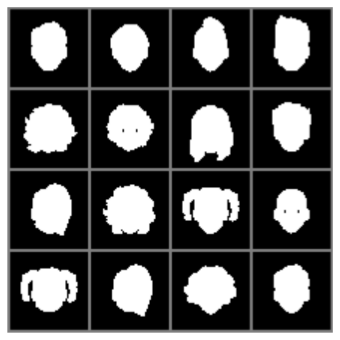

In [24]:
def sample(model, img_shape, z_init=None):
        """
        Sample a batch of images from the flow.
        """
        # Sample latent representation from prior
        if z_init is None:
            z = model.prior.sample(sample_shape=img_shape).to(device)
        else:
            z = z_init.to(device)
        
        # Transform z to x by inverting the flows
        ldj = torch.zeros(img_shape[0], device=device)  
        for flow in reversed(model.flows): 
            z, ldj = flow(z, ldj, reverse=True)
        return z 


def show_imgs(imgs, title=None, row_size=4, cmap=plt.cm.binary):
    # Form a grid of pictures (we use max. 8 columns)
    num_imgs = imgs.shape[0] if isinstance(imgs, torch.Tensor) else len(imgs)
    is_int = imgs.dtype==torch.int32 if isinstance(imgs, torch.Tensor) else imgs[0].dtype==torch.int32
    nrow = min(num_imgs, row_size)
    ncol = int(math.ceil(num_imgs/nrow))
    imgs = torchvision.utils.make_grid(imgs, nrow=nrow, pad_value=128 if is_int else 0.5) 
    np_imgs = imgs.cpu().numpy()
    # Plot the grid
    plt.figure(figsize=(1.5*nrow, 1.5*ncol))
    plt.imshow(np.transpose(np_imgs, (1,2,0)), interpolation='bilinear', cmap=cmap)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.show()
    plt.close()

show_imgs([train_set[i][0] for i in range(16,32)]) 

In [25]:
def create_multiscale_flow():
    flow_layers = []
    
    vardeq_layers = [CouplingLayer(network=GatedConvNet(c_in=2, c_out=2, c_hidden=16),
                                   mask=create_checkerboard_mask(h=52, w=52, invert=(i%2==1)),
                                   c_in=1) for i in range(4)]
    flow_layers += [VariationalDequantization(vardeq_layers)]
    
    flow_layers += [CouplingLayer(network=GatedConvNet(c_in=1, c_hidden=32),
                                  mask=create_checkerboard_mask(h=52, w=52, invert=(i%2==1)),
                                  c_in=1) for i in range(2)]
    flow_layers += [SqueezeFlow()]
    for i in range(2):
        flow_layers += [CouplingLayer(network=GatedConvNet(c_in=4, c_hidden=48),
                                      mask=create_channel_mask(c_in=4, invert=(i%2==1)),
                                      c_in=4)]
    flow_layers += [SplitFlow(),
                    SqueezeFlow()]
    for i in range(4):
        flow_layers += [CouplingLayer(network=GatedConvNet(c_in=8, c_hidden=64),
                                      mask=create_channel_mask(c_in=8, invert=(i%2==1)),
                                      c_in=8)]

    flow_model = ImageFlow(flow_layers).to(device)
    return flow_model

In [ ]:
# model_no_aux = train_flow(create_simple_flow(use_vardeq=True)) 
model_multi_no_aux = train_flow(create_multiscale_flow()) 

In [ ]:
model = model_multi_no_aux[0] 

Global seed set to 435


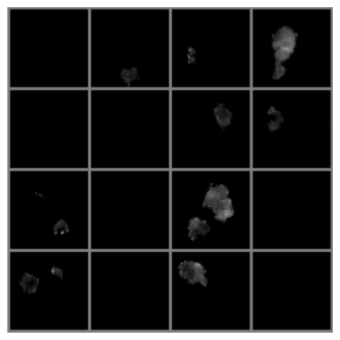

In [ ]:
pl.seed_everything(435) 
samples = sample(model, img_shape=(16,8,13,13))
show_imgs(samples, cmap=plt.cm.binary) 

In [ ]:
samples2 = train_set[1][0].numpy() 

for i in range(1, 16): 
    _sample = train_set[i][0].numpy() 
    samples2 = np.concatenate([samples2, _sample], axis=0) 
    

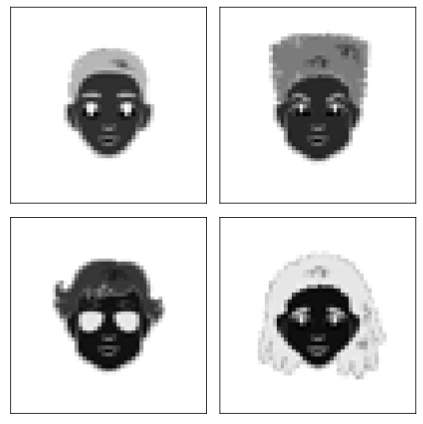

In [ ]:
# _samples = samples.numpy().squeeze() 
_samples = samples2

plt.figure(figsize=(6,6)) 
plt.subplot(221) 
plt.imshow(_samples[3], plt.cm.binary) 
plt.grid(False) 
plt.xticks([]) 
plt.yticks([])

plt.subplot(222) 
plt.imshow(_samples[10], plt.cm.binary) 
plt.grid(False)
plt.xticks([]) 
plt.yticks([]) 

plt.subplot(223) 
plt.imshow(_samples[14], plt.cm.binary) 
plt.grid(False)
plt.xticks([]) 
plt.yticks([])

plt.subplot(224) 
plt.imshow(_samples[12], plt.cm.binary) 
plt.grid(False)
plt.xticks([]) 
plt.yticks([]) 
plt.tight_layout()
plt.show()

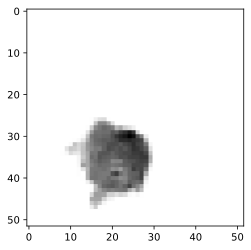

In [ ]:
i = np.random.randint(0, 16)
plt.imshow(samples[i].squeeze(), plt.cm.binary) 
plt.show()